In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

n = 10_000  # número de vértices
target_k = 20.0  # grau médio desejado
p = target_k / (n - 1)  # Probabilidade de conexão

rng = np.random.default_rng(42)

G = nx.fast_gnp_random_graph(n, p, seed=42)

A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)

In [2]:
deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
print(f"Rede criada: N={n}, k médio={emp_k:.2f}")

Rede criada: N=10000, k médio=19.97


In [3]:
def simulate_SIS_sparse(A, beta, mu, T=100, runs=100, initial_infected=5):
    rng = np.random.default_rng(42)
    n = A.shape[0]
    prevalence_runs = np.zeros((runs, T))

    for r in range(runs):
        # Estado inicial: todos suscetíveis (False), exceto 5 infectados
        infected = np.zeros(n, dtype=bool)
        seeds = rng.choice(n, initial_infected, replace=False)
        infected[seeds] = True

        for t in range(T):
            # Registra a fração de infectados no tempo t
            prevalence_runs[r, t] = infected.mean()

            # 1. Processo de Recuperação I para S
            # Cada nó infectado se recupera com probabilidade mu
            recover_prob = rng.random(n)
            just_recovered = infected & (recover_prob < mu)
            infected[just_recovered] = False

            # 2. Processo de Infecção S para I
            # Contar vizinhos infectados para cada nó
            inf_neighbors_count = A.dot(infected.astype(np.int8))
            susceptible = ~infected
            k_inf = inf_neighbors_count[susceptible]

            p_infection = 1.0 - np.power(1.0 - beta, k_inf)

            new_inf_mask = rng.random(len(k_inf)) < p_infection

            infected[susceptible] = new_inf_mask

    # Calcula média e desvio padrão entre as execuções
    mean_prev = prevalence_runs.mean(axis=0)
    std_prev = prevalence_runs.std(axis=0)

    return mean_prev, std_prev

Simulando: β=0.02, μ=0.1 (R0 ≈ 3.99)


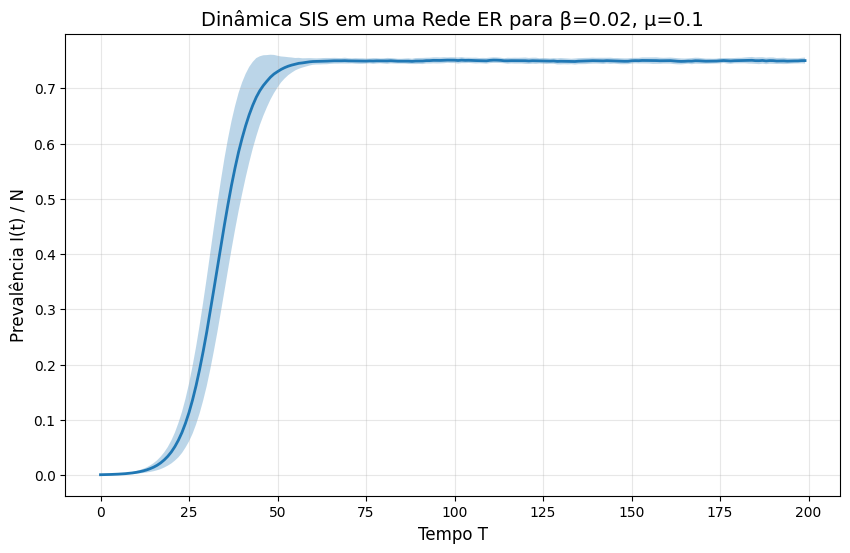

Simulando: β=0.02, μ=0.4 (R0 ≈ 1.00)


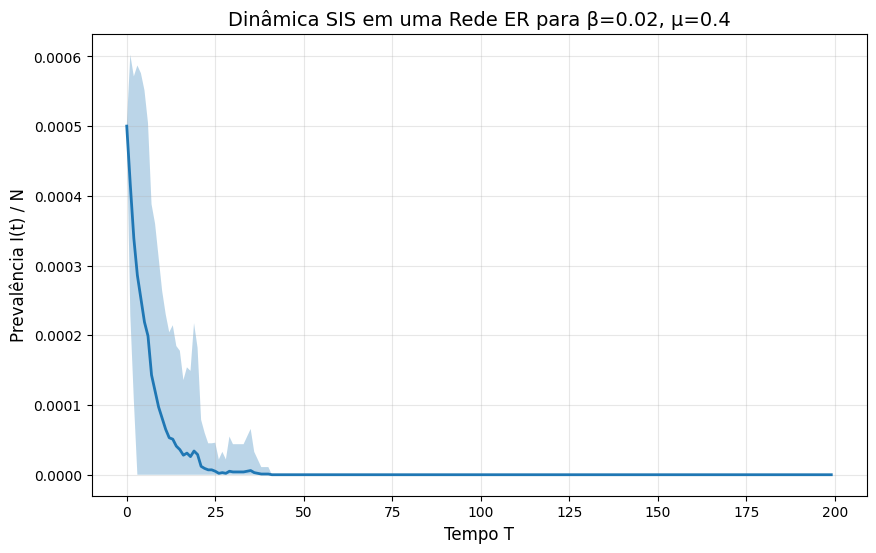

Simulando: β=0.02, μ=0.5 (R0 ≈ 0.80)


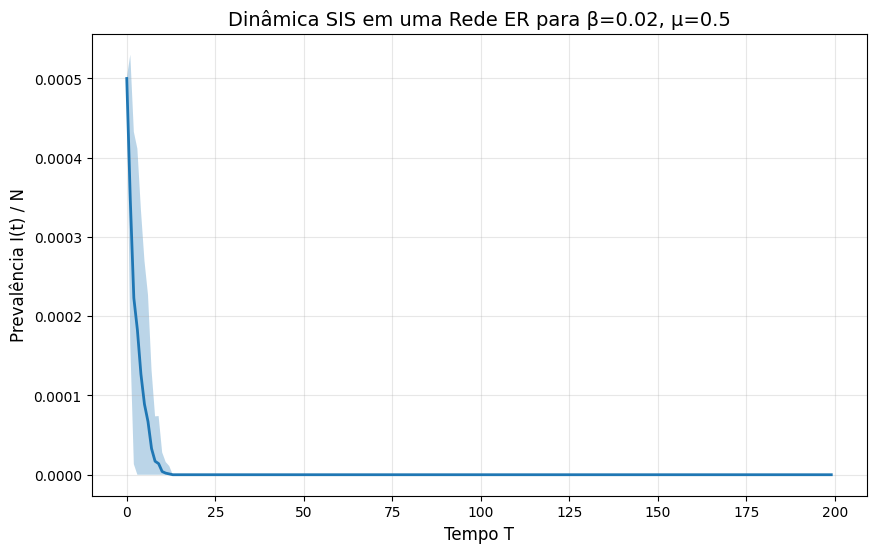

In [4]:
scenarios = [(0.02, 0.1), (0.02, 0.4), (0.02, 0.5)]

results = {}
degree_mean = emp_k


for beta, mu in scenarios:
    R0 = (beta * degree_mean) / mu

    print(f"Simulando: β={beta}, μ={mu} (R0 ≈ {R0:.2f})")

    mean_prev, std_prev = simulate_SIS_sparse(A, beta, mu, T=200, runs=100)
    results[(beta, mu)] = (mean_prev, std_prev, R0)

    plt.figure(figsize=(10, 6))
    steps = np.arange(len(mean_prev))
    plt.plot(
        steps,
        mean_prev,
        linewidth=2,
    )
    plt.fill_between(
        steps,
        np.maximum(0, mean_prev - std_prev),
        np.minimum(1, mean_prev + std_prev),
        alpha=0.3,
    )
    plt.title(
        f"Dinâmica SIS em uma Rede ER para β={beta}, μ={mu}", fontsize=14
    )
    plt.xlabel("Tempo T", fontsize=12)
    plt.ylabel("Prevalência I(t) / N", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
data_rows = []
for (beta, mu), (mean_arr, std_arr, R0) in results.items():
    final_prev = mean_arr[-20:].mean()
    final_std = std_arr[-20:].mean()

    theoretical_prev = max(0, 1 - (1 / R0)) if R0 > 0 else 0

    data_rows.append(
        {
            "β": beta,
            "μ": mu,
            "R0 Estimado": round(R0, 2),
            "Prevalência Simulada (final)": round(final_prev, 4),
            "Prevalência Teórica (1 - 1/R0)": round(theoretical_prev, 4),
        }
    )

df_results = pd.DataFrame(data_rows)
display(df_results)

,β,μ,R0 Estimado,Prevalência Simulada (final),Prevalência Teórica (1 - 1/R0)
0,0.02,0.1,3.99,0.75,0.7496
1,0.02,0.4,1.00,0.00,0.0000
2,0.02,0.5,0.80,0.00,0.0000


### Discussão dos Resultados

O modelo SIS em uma rede homogênea (como a rede aleatória Erdős-Rényi gerada, onde a distribuição de graus é de Poisson e bem comportada em torno da média $\langle k \rangle \approx 20$) segue de perto as previsões da teoria de campo médio.

O parâmetro fundamental para determinar o comportamento da epidemia é o número básico de reprodução, dado por:
$$R_0 = \frac{\beta \langle k \rangle}{\mu}$$

Onde:

1.  Se **$R_0 > 1$**: A epidemia atinge um estado endêmico estável com prevalência $i = 1 - \frac{1}{R_0}$.
2.  Se **$R_0 \le 1$**: A doença não consegue se sustentar e a prevalência tende a zero (estado livre de doença).

#### 1. Análise dos Cenários

Observando o gráfico e a tabela gerada, podemos distinguir claramente os regimes de comportamento da epidemia baseados nos parâmetros fornecidos:

*   **Cenário A ($\beta=0.02, \mu=0.1$) - Endêmico:**

    * Temos $R_0 = \frac{0.02 \times 20}{0.1} = 4.0$.
    *   Aqui, o $R_0 \approx 4.0$. Como $R_0 > 1$, a doença se espalha rapidamente e atinge um equilíbrio estável onde cerca de **75%** da rede permanece infectada. A simulação converge muito próximo do valor teórico de campo médio ($1 - 1/4 = 0.75$).
*   **Cenário B ($\beta=0.02, \mu=0.4$) - Crítico/Transição:**

    * Temos $R_0 = \frac{0.02 \times 20}{0.4} = 1.0$.
    *   Neste caso, $R_0 \approx 1.0$. Estamos no limiar da transição de fase. Teoricamente, a prevalência tenderia a zero ou seria instável. Na simulação finita, vemos uma prevalência muito baixa ou nula. A infecção luta para sobreviver e, devido a flutuações estocásticas, tende a extinguir-se rapidamente.
*   **Cenário C ($\beta=0.02, \mu=0.5$) - Livre de Doença:**
    
    * Temos $R_0 = \frac{0.02 \times 20}{0.5} = 0.8$.
    *   Aqui, $R_0 \approx 0.8$. Como $R_0 < 1$, a taxa de recuperação supera a capacidade de infecção. A epidemia não consegue se sustentar e decai exponencialmente para zero logo após o início.


**Conclusão:**
Os experimentos numéricos validam a condição de limiar epidêmico. A doença só se fixa na rede (torna-se endêmica) quando a taxa de infecção ponderada pela conectividade média supera a taxa de recuperação ($R_0 > 1$), conforme previsto pela equação de campo médio para redes homogêneas. Os resultados da simulação confirmam esta análise, onde apenas o cenário com $R_0=4$ manteve uma população infectada significativa.